Importing Libraries

In [ ]:
#All the libraries are impoted
import argparse
import math
import warnings
import numpy as np
import pandas as pd
# from data.data import process_data
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.callbacks import EarlyStopping
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Seaborn for Data Visualization
import seaborn as sns
warnings.filterwarnings("ignore")\
# plt.style.use('seaborn-darkgrid')

Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Data into Pandas Data Frame

In [ ]:
attr = 'AggFlow'
df = pd.read_csv('drive/MyDrive/Data/inputs.csv', encoding='utf-8').fillna(0)
df1 = df.iloc[:74880]
df2 = df.iloc[74880:]

Data Preprocessing

In [ ]:
#Appending year, month and day from the timestamp
df['Timestamp'] = df['Timestamp'].astype('datetime64[ns]')
df['weekday'] = df['Timestamp'].dt.weekday

# Feature engineering with the date
df['year']= df['Timestamp'].dt.year 
df['month']= df['Timestamp'].dt.month 
df['day']= df['Timestamp'].dt.day

df.head(3)

original_df = df.copy()

In [ ]:
df

,Timestamp,AggFlow,# Lane Points,% Observed,weekday,year,month,day
0,2021-01-01 00:00:00,110,4,0,4,2021,1,1
1,2021-01-01 00:05:00,117,4,0,4,2021,1,1
2,2021-01-01 00:10:00,120,4,0,4,2021,1,1
3,2021-01-01 00:15:00,113,4,0,4,2021,1,1
4,2021-01-01 00:20:00,131,4,0,4,2021,1,1
...,...,...,...,...,...,...,...,...
91579,2021-11-29 23:35:00,78,4,0,0,2021,11,29
91580,2021-11-29 23:40:00,79,4,0,0,2021,11,29
91581,2021-11-29 23:45:00,77,4,0,0,2021,11,29
91582,2021-11-29 23:50:00,75,4,0,0,2021,11,29


In [ ]:
#Replacing Week day with string for better understanding
df['weekday_num'] = df['weekday']
df['weekday'].replace(0,'01 - Monday',inplace=True)
df['weekday'].replace(1,'02 - Tuesday',inplace=True)
df['weekday'].replace(2,'03 - Wednesday',inplace=True)
df['weekday'].replace(3,'04 - Thursday',inplace=True)
df['weekday'].replace(4,'05 - Friday',inplace=True)
df['weekday'].replace(5,'06 - Saturday',inplace=True)
df['weekday'].replace(6,'07 - Sunday',inplace=True)

df

,Timestamp,AggFlow,# Lane Points,% Observed,weekday,year,month,day,weekday_num
0,2021-01-01 00:00:00,110,4,0,05 - Friday,2021,1,1,05 - Friday
1,2021-01-01 00:05:00,117,4,0,05 - Friday,2021,1,1,05 - Friday
2,2021-01-01 00:10:00,120,4,0,05 - Friday,2021,1,1,05 - Friday
3,2021-01-01 00:15:00,113,4,0,05 - Friday,2021,1,1,05 - Friday
4,2021-01-01 00:20:00,131,4,0,05 - Friday,2021,1,1,05 - Friday
...,...,...,...,...,...,...,...,...,...
91579,2021-11-29 23:35:00,78,4,0,01 - Monday,2021,11,29,01 - Monday
91580,2021-11-29 23:40:00,79,4,0,01 - Monday,2021,11,29,01 - Monday
91581,2021-11-29 23:45:00,77,4,0,01 - Monday,2021,11,29,01 - Monday
91582,2021-11-29 23:50:00,75,4,0,01 - Monday,2021,11,29,01 - Monday


Data Visluatization

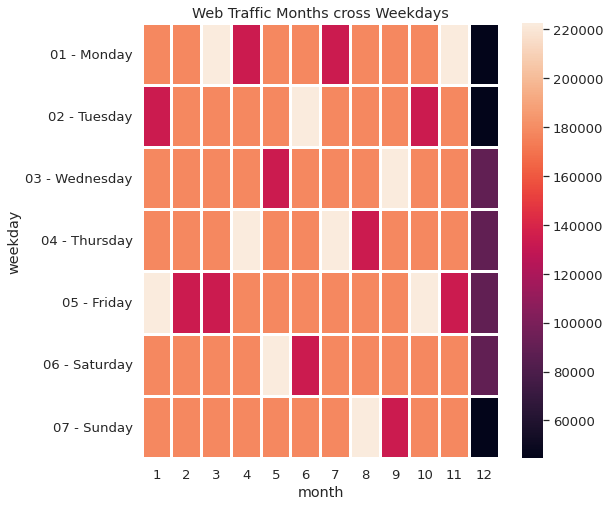

In [ ]:
train_group = df.groupby(["month", "weekday"])['AggFlow'].sum().reset_index()
train_group = train_group.pivot('weekday','month','AggFlow')
train_group.sort_index(inplace=True)

import seaborn as sns
sns.set(font_scale=1.2) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

Data Preprocessing

In [ ]:
#Importing Cleaned CSV for Speed, Flow and Occupancy
def process_data(lags):

    # Flow
    attr = 'AggFlow'
    df = pd.read_csv('drive/MyDrive/Data/inputs.csv', encoding='utf-8').fillna(0)
    df1 = df.iloc[:74880]
    df2 = df.iloc[74880:]


    #Speed
    attr = 'AggSpeed'
    df = pd.read_csv('drive/MyDrive/Data/Input_speed.csv', encoding='utf-8').fillna(0)
    df1 = df.iloc[:74880]
    df2 = df.iloc[74880:]

    #Occupancy
    attr = 'AggOccupancy'
    df = pd.read_csv('drive/MyDrive/Data/Input_occ.csv', encoding='utf-8').fillna(0)
    df1 = df.iloc[:74880]
    df2 = df.iloc[74880:]



    #Using Min Max Scaler for changing the range of data
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    train, test = [], []
    # lag in the data
    lags = 12
    #Adding lag to the data 
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])
    
    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    #Returning Training and Testing data
    return X_train, y_train, X_test, y_test, scaler

Declaring Models

In [ ]:
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential

Defining Architecture of Models

In [ ]:
#Building LSTM model
def get_lstm(units):
    model = Sequential()
    model.add(LSTM(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(LSTM(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

#Building GRU model
def get_gru(units):
    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

#Building SAE model
def _get_sae(inputs, hidden, output):
    model = Sequential()
    model.add(Dense(hidden, input_dim=inputs, name='hidden'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(output, activation='sigmoid'))

    return model

#Building SAES model
def get_saes(layers):
    saes = Sequential()
    saes.add(Dense(layers[1], input_dim=layers[0], name='hidden1'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[2], name='hidden2'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[3], name='hidden3'))
    saes.add(Activation('sigmoid'))
    saes.add(Dropout(0.2))
    saes.add(Dense(layers[4], activation='sigmoid'))

    models = [saes]

    return models

Training Models

In [ ]:
def train_model(model, X_train, y_train, name, config):

    #Compiling the model with Adam Optimizer  
    model.compile(loss="mse", optimizer="adam", metrics=['mape'])
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        validation_split=0.05)
    
    #Plotting Train vs Validation loss graph
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    #Saving model and loss as .h5 file for future reference
    model.save('model/' + name + '.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('model/' + name + ' loss.csv', encoding='utf-8', index=False)

#Training the SAES models
def train_seas(models, X_train, y_train, name, config):
    temp = X_train

    saes = models[-1]
    for i in range(1, 4):
      weights = saes.get_layer('hidden%d' % (i)).get_weights()
      saes.get_layer('hidden%d' % (i)).set_weights(weights)
    train_model(saes, X_train, y_train, name, config)





Processing the data

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--model", 
    default="saes", 
    help="Model to train.")
#args = parser.parse_args()
args, unknown = parser.parse_known_args()
# args.model = 'gru'

lag = 12
config = {"batch": 256, "epochs": 200}
X_train, y_train, X_test, y_test, scaler = process_data(lag)

Getting the Shape of Data

In [ ]:
X_train.shape

(74868, 12)

In [ ]:
X_test.shape

(16692, 12)

Running the Models

Epoch 1/200
278/278 [==============================] - 5s 16ms/step - loss: 0.0302 - mape: 508523.7188 - val_loss: 0.0110 - val_mape: 319809.7188
Epoch 2/200
278/278 [==============================] - 4s 16ms/step - loss: 0.0099 - mape: 325428.2812 - val_loss: 0.0095 - val_mape: 302543.4375
Epoch 3/200
278/278 [==============================] - 5s 17ms/step - loss: 0.0086 - mape: 300036.3750 - val_loss: 0.0087 - val_mape: 286738.8125
Epoch 4/200
278/278 [==============================] - 5s 20ms/step - loss: 0.0082 - mape: 294937.9375 - val_loss: 0.0082 - val_mape: 235212.9375
Epoch 5/200
278/278 [==============================] - 7s 24ms/step - loss: 0.0079 - mape: 281203.0312 - val_loss: 0.0080 - val_mape: 242620.3594
Epoch 6/200
278/278 [==============================] - 6s 20ms/step - loss: 0.0077 - mape: 271696.3750 - val_loss: 0.0078 - val_mape: 215666.1719
Epoch 7/200
278/278 [==============================] - 7s 23ms/step - loss: 0.0076 - mape: 254625.1094 - val_loss: 0.0078 - 

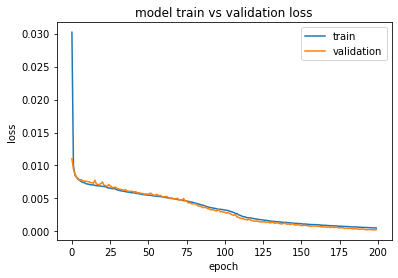

In [ ]:
if args.model == 'lstm':
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    m = get_lstm([12, 64, 64, 1])
    train_model(m, X_train, y_train, 'lstm', config)


if args.model == 'gru':
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    m = get_gru([12, 64, 64, 1])
    train_model(m, X_train, y_train, 'gru', config)


if args.model == 'saes':
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    m = get_saes([12, 400, 400, 400, 1])
    train_seas(m, X_train, y_train, 'saes', config)

Predict Results

In [ ]:
#Defining the MAPE metric score
def MAPE(y_true, y_pred):
    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape

#Computing all the evaluation metrics for the model accuracy
def eva_regress(y_true, y_pred):
    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)

#Plotting the Results
def plot_results(y_true, y_preds, names):
    d = '2021-10-1 00:00:00'
    x = pd.date_range(d, periods=16692, freq='5min')

    fig = plt.figure(figsize=(35, 8))
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Occupancy')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    plt.savefig('saes_speed_200.png')
    plt.show()

Predicitons using the Models

In [ ]:
lstm = load_model('model/lstm.h5')
gru = load_model('model/gru.h5')
saes = load_model('model/saes.h5')
models = [lstm, gru, saes]
names = ['LSTM', 'GRU', 'SAEs']

y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

y_preds = []

if names[0] == 'SAEs':
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
else:
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
plot_model(gru, show_shapes=True)
predicted = gru.predict(X_test)
plot_model(lstm, show_shapes=True)
predicted = lstm.predict(X_test)
plot_model(saes, show_shapes=True)
predicted = saes.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
y_preds.append(predicted)
eva_regress(y_test, predicted)

explained_variance_score:0.997204
mape:2.428153%
mae:2.743688
mse:17.609320
rmse:4.196346
r2:0.996810


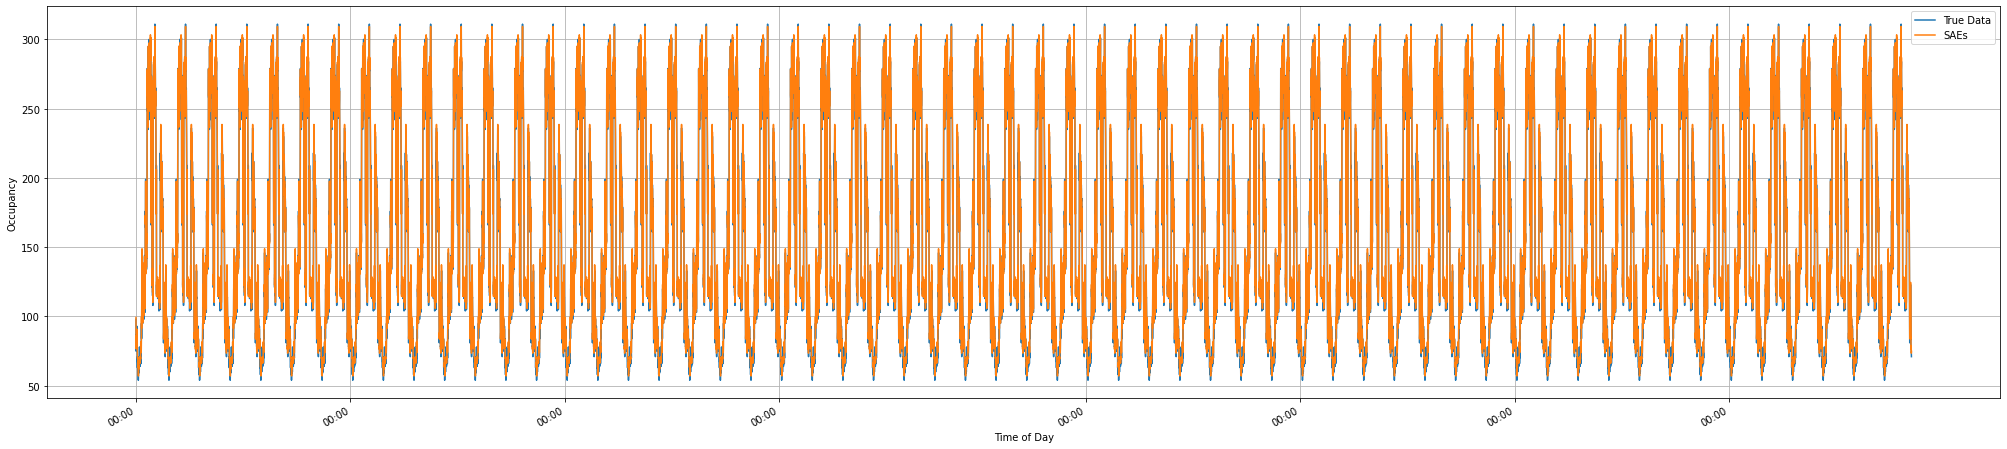

In [ ]:
plot_results(y_test, y_preds, names)

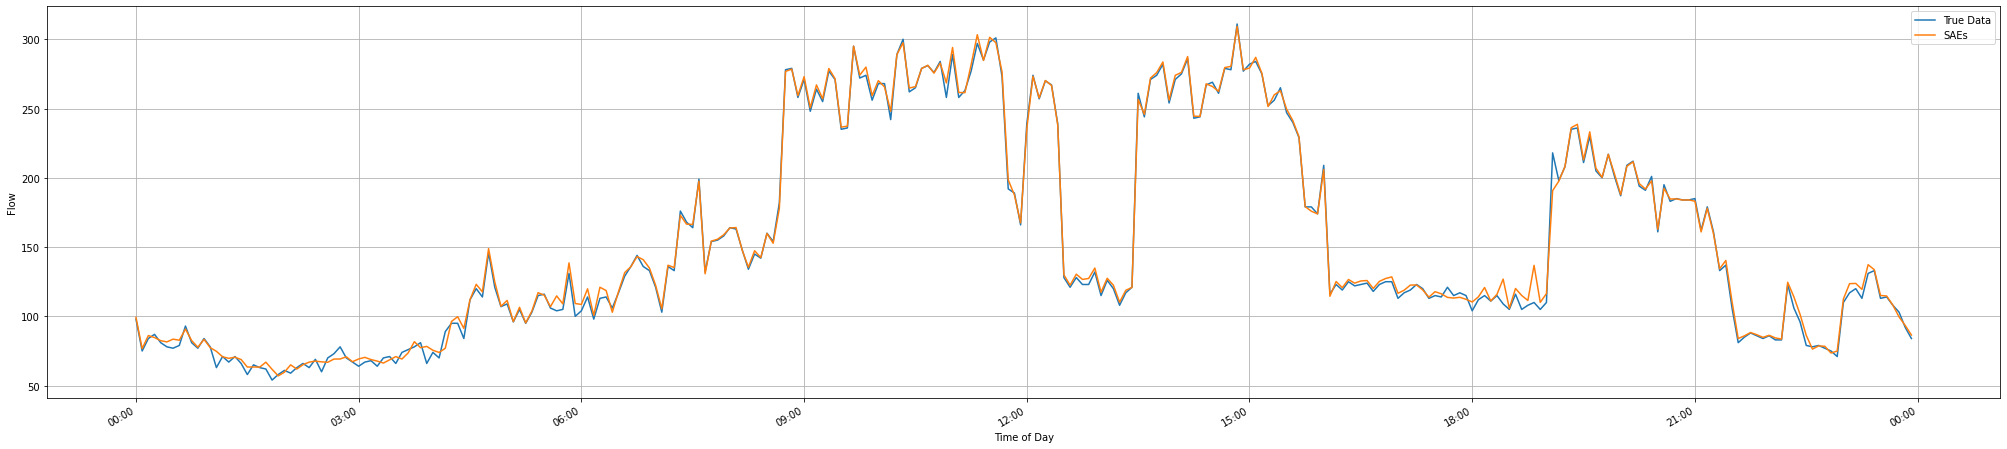

In [ ]:
# plot_one_day_results(y_test[:288], predict, names)
d = '2021-10-1 00:00:00'
x = pd.date_range(d, periods=288, freq='5min')

fig = plt.figure(figsize=(35, 8))
ax = fig.add_subplot(111)

ax.plot(x, y_test[:288], label='True Data')
for name, y_pred in zip(names, y_preds):
    ax.plot(x, y_pred[:288], label=name)

plt.legend()
plt.grid(True)
plt.xlabel('Time of Day')
plt.ylabel('Flow')

date_format = mpl.dates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
plt.savefig('gru_occ2.png')

Plotting graphs of Evaluation Metrics (Model Comparison)

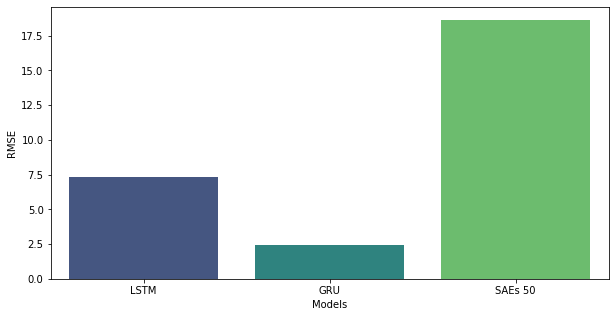

In [ ]:
plt.figure(figsize=(10,5))
X = ['LSTM', 'GRU', 'SAEs 50']
Y = [7.3362, 2.414, 18.640]
ax =sns.barplot(x = X, y = Y, palette = 'viridis')
ax.set(xlabel = "Models", ylabel = "RMSE")
plt.show()


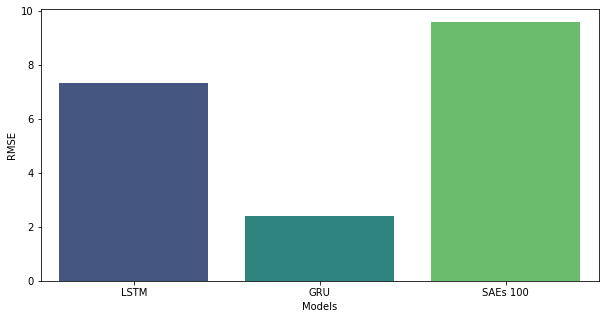

In [ ]:
plt.figure(figsize=(10,5))
X = ['LSTM', 'GRU', 'SAEs 100']
Y = [7.3362, 2.414, 9.5910]
ax =sns.barplot(x = X, y = Y, palette = 'viridis')
ax.set(xlabel = "Models", ylabel = "RMSE")
plt.show()

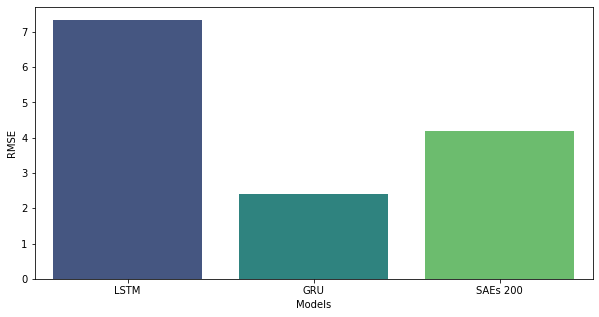

In [ ]:
plt.figure(figsize=(10,5))
X = ['LSTM', 'GRU', 'SAEs 200']
Y = [7.3362, 2.414, 4.1910]
ax =sns.barplot(x = X, y = Y, palette = 'viridis')
ax.set(xlabel = "Models", ylabel = "RMSE")
plt.show()

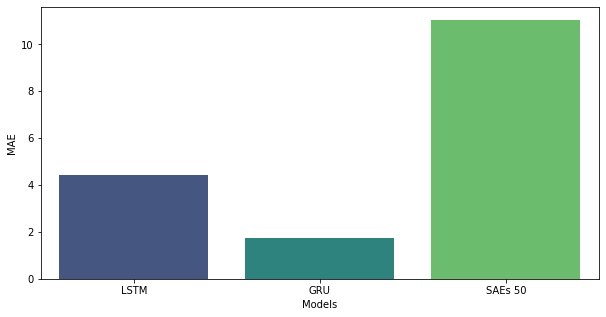

In [ ]:
plt.figure(figsize=(10,5))
X = ['LSTM', 'GRU', 'SAEs 50']
Y = [4.444, 1.724, 11.0409]
ax =sns.barplot(x = X, y = Y, palette = 'viridis')
ax.set(xlabel = "Models", ylabel = "MAE")
plt.show()

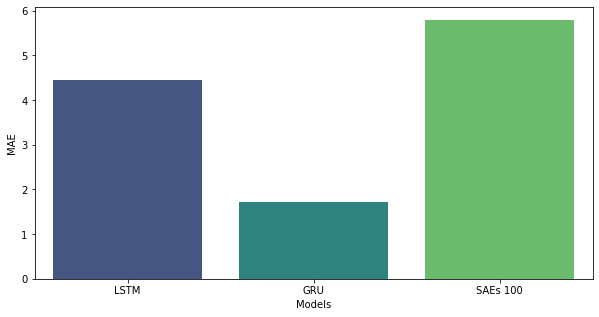

In [ ]:
plt.figure(figsize=(10,5))
X = ['LSTM', 'GRU', 'SAEs 100']
Y = [4.444, 1.724, 5.79]
ax =sns.barplot(x = X, y = Y, palette = 'viridis')
ax.set(xlabel = "Models", ylabel = "MAE")
plt.show()

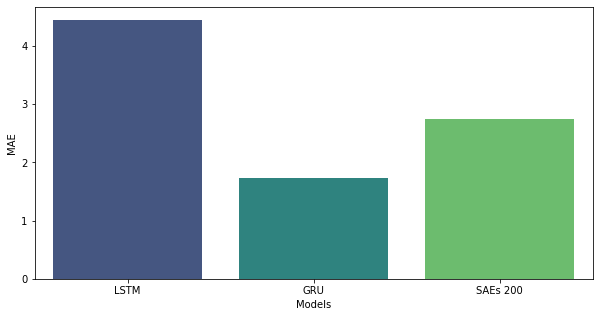

In [ ]:
plt.figure(figsize=(10,5))
X = ['LSTM', 'GRU', 'SAEs 200']
Y = [4.444, 1.724, 2.743688]
ax =sns.barplot(x = X, y = Y, palette = 'viridis')
ax.set(xlabel = "Models", ylabel = "MAE")
plt.show()